# Klasterizavimas.  K-vidurkių metodas
## _Apache Spark Mllib KMeans_

### 1 pavyzdys

#### CA1 duomenų failas

Šiame pavyzdyje paprastumo dėlei naudosime $\mathbb{R}^2$ erdvės duomenis.

Konvertuojame _MS Excel_ `.xls` formato failą į `.csv` formato failą.

In [39]:
! in2csv --sheet "CA1" data/CA1.xls > data/CA1.csv

Išvedame failo pirmąją eilutę, t.y. stulpelių pavadinimus.

In [44]:
! head -n 1 data/CA1.csv

ID,X,Y,klasteris


Įkeliame `.csv` formato duomenų failą. Įkėlimo metu galime pakeisti stulpelių pavadinimus naudodami `pyspark.sql.DataFrame` metodą `withColumnRenamed` arba iš įkelto `pyspark.sql.DataFrame` gauti `RDD` (`pyspark.sql.DataFrame` atributas `rdd`) ir vėl paversti į `pyspark.sql.DataFrame` panaudojant `RDD` metodą `toDF` su naujų stulpelių pavadinimų sąrašo argumentu.

In [40]:
ca1DF = (
    sqlContext.read.load("data/CA1.csv", format="com.databricks.spark.csv", header=True, inferSchema=True)
    # .withColumnRenamed("ID", "id")
    # .withColumnRenamed("X", "x")
    # .withColumnRenamed("Y", "y")
    # .withColumnRenamed("klasteris", "cluster")
    .rdd.toDF(["id", "x", "y", "cluster"])
)

ca1DF.show(5)

+---+------------+------------+-------+
| id|           x|           y|cluster|
+---+------------+------------+-------+
|  1|-0.485694686| 2.075174209|      1|
|  2|  -0.3682471| 2.037708135|      2|
|  3|-1.409078419|-1.371631094|      3|
|  4|-1.434896397|-1.959709476|      4|
|  5| 3.706690333|-0.803240913|      5|
+---+------------+------------+-------+
only showing top 5 rows



Importuojame _Apache Spark Mllib_ K-vidurkių klasteriavimo klasę ir vektorių klasę.

In [41]:
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import DenseVector

Pamename, kad `pyspark.sql.DataFrame` atributo `rdd` reikšmė `pyspark.sql.Row` tipo objektų `RDD` objektas:

In [46]:
ca1DF.rdd.take(5)

[Row(id=1, x=-0.485694686, y=2.075174209, cluster=1),
 Row(id=2, x=-0.3682471, y=2.037708135, cluster=2),
 Row(id=3, x=-1.409078419, y=-1.371631094, cluster=3),
 Row(id=4, x=-1.434896397, y=-1.959709476, cluster=4),
 Row(id=5, x=3.706690333, y=-0.803240913, cluster=5)]

`pyspark.mllib` paketas yra pritaikytas dirbti su `RDD` tipo objektais, todėl iš turimo `pyspark.sql.DataFrame` sudarome požymių `RDD` iš `x` ir `y` stulpelių. 

In [47]:
featuresRDD = ca1DF.rdd.map(lambda row: DenseVector([row.x, row.y]))
featuresRDD.take(5)

[DenseVector([-0.4857, 2.0752]),
 DenseVector([-0.3682, 2.0377]),
 DenseVector([-1.4091, -1.3716]),
 DenseVector([-1.4349, -1.9597]),
 DenseVector([3.7067, -0.8032])]

Parenkame parametrą $k=2$ ir apmokome pirmą K-vidurkių modelį. `pyspark.mllib.clustering.KMeans` metodo `train` argumentų paaiškinimas yra [čia](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=mllib%20kmeans#pyspark.mllib.clustering.KMeans).

In [48]:
firstModel = KMeans.train(
    featuresRDD, k=2, maxIterations=10, 
    runs=10, initializationMode="k-means||", seed=1)

Apmokyto modelio klasterių centrus galime pasiekti per modelio (kurio tipas `pyspark.mllib.clustering.KMeansModel`) atributą `centers`:

In [55]:
type(firstModel)

pyspark.mllib.clustering.KMeansModel

In [56]:
firstModel.centers

[array([-0.92282928,  0.20079515]), array([ 3.69629649, -0.80680897])]

`pyspark.mllib.clustering.KMeansModel` metodas `computeCost` apskaičiuoja stebėjimų Euklido atstumų nuo savo klasterių  centrų sumą $S_K$ (angl. _Within Set Sum of Squared Error (WSSSE)_):

$I_k = \sum_{\mathbf{x}_i \in C_k} \| \mathbf{x}_i - \mathbf{\overline{x}}_k \|$

$S_K = \sum_{k}^{K} I_k$

čia 

$k$ - klasterio indeksas,

$C_k$ - $k$-asis klasteris

$K$ - klasterių skaičius,

$N_k$ - $k$-jam klasteriui priklausančių stebėjimų skaičius,

$\mathbf{x_i}$ - $i$-tojo stebėjimo vektorius,

$\mathbf{\overline{x}}_k$ - $k$-otojo klasterio vidurinio taško (centro) vektorius,

$\|\mathbf{x}\|$ - vektoriaus Euklido norma, t.y. kvadratinė šaknis iš jo komponenčių kvadratų sumos.

In [57]:
firstModel.computeCost(featuresRDD)

1504.98682886255

* * *
**_Pastaba:_** $S_K$ galime apskaičiuoti ir patys:

In [60]:
featuresRDD.map(lambda point: point.squared_distance(firstModel.centers[firstModel.predict(point)])).sum()

1504.9868288625503

Aiškumo dėlei išskaidome šią išraišką į keletą funkcijų:

In [63]:
def computeWSSSE(vectorRDD, model):
    return vectorRDD.map(lambda point: squaredDistance(point, model)).sum()

def squaredDistance(point, kmeansModel):
    center = kmeansModel.centers[kmeansModel.predict(point)]
    return point.squared_distance(center)

In [64]:
computeWSSSE(featuresRDD, firstModel)

1504.9868288625503


* * *

Modelio parametrą $K = 2$ parinkome intuityviai, tačiau ar galime vien iš šios metrikos pasakyti ar tai optimali $K$ reikšmė?

Kadangi naudojame $\mathbb{R}^2$ duomenis, nubraižysime sklaidos diagramą. Grafikų braižymui naudosime [_R_](https://www.r-project.org/) paketo [`ggplot2`](http://docs.ggplot2.org/) _Python_ atitikmenį [`ggplot`](http://ggplot.yhathq.com/).

Pirmiausia prie turimų stebėjimų prijungsime ką tik apmokyto modelio prognozuojamų klasterių indeksus.

Sukuriame naują `pyspark.sql.Row` klasę su atitinkamias stulpelių pavadinimais.

In [49]:
from pyspark.sql import Row

predRow = Row("id", "x", "y", "prediction")

Naudodami apmokytą modelį atliekame stebėjimų priklausymo klasteriams prognozavimą ir patogumo dėlei sukuriame naują `pyspark.sql.DataFrame` su prognozavimo rezultatais.

In [52]:
ca1WithPredRDD = ca1DF.rdd.map(lambda r: predRow(r.id, r.x, r.y, firstModel.predict(DenseVector([r.x, r.y]))))
ca1WithPredRDD.take(10)

[Row(id=1, x=-0.485694686, y=2.075174209, prediction=0),
 Row(id=2, x=-0.3682471, y=2.037708135, prediction=0),
 Row(id=3, x=-1.409078419, y=-1.371631094, prediction=0),
 Row(id=4, x=-1.434896397, y=-1.959709476, prediction=0),
 Row(id=5, x=3.706690333, y=-0.803240913, prediction=1),
 Row(id=6, x=-0.488402521, y=2.076363672, prediction=0),
 Row(id=7, x=-0.365141811, y=2.053486526, prediction=0),
 Row(id=8, x=-1.403284478, y=-1.387871943, prediction=0),
 Row(id=9, x=-1.443300554, y=-1.940563955, prediction=0),
 Row(id=10, x=3.692759351, y=-0.811397504, prediction=1)]

Iš `RDD` objekto sukuriame `pyspark.sql.DataFrame` objektą.

In [53]:
ca1WithPredDF = ca1WithPredRDD.toDF()
ca1WithPredDF.show(10)

+---+------------+------------+----------+
| id|           x|           y|prediction|
+---+------------+------------+----------+
|  1|-0.485694686| 2.075174209|         0|
|  2|  -0.3682471| 2.037708135|         0|
|  3|-1.409078419|-1.371631094|         0|
|  4|-1.434896397|-1.959709476|         0|
|  5| 3.706690333|-0.803240913|         1|
|  6|-0.488402521| 2.076363672|         0|
|  7|-0.365141811| 2.053486526|         0|
|  8|-1.403284478|-1.387871943|         0|
|  9|-1.443300554|-1.940563955|         0|
| 10| 3.692759351|-0.811397504|         1|
+---+------------+------------+----------+
only showing top 10 rows



Klasterio indeksai atitinka klasterio centrų indeksus:

In [27]:
list(enumerate(firstModel.centers))

[(0, array([-0.92282928,  0.20079515])),
 (1, array([ 3.69629649, -0.80680897]))]

_Python_ `ggplot` paketas naudoja _Python_ `pandas` paketo duomenų rinkinius `pandas.DataFrame`. Iškvietus _Apache Spark_ `pyspark.sql.DataFrame` metodą `toPandas` gauname `pandas.DataFrame` objektą kurį naudojame sklaidos diagramos braižymui.

In [58]:
# grafikų braižymui Jupyter Notebook ląstelėse
%matplotlib inline
import ggplot as gg

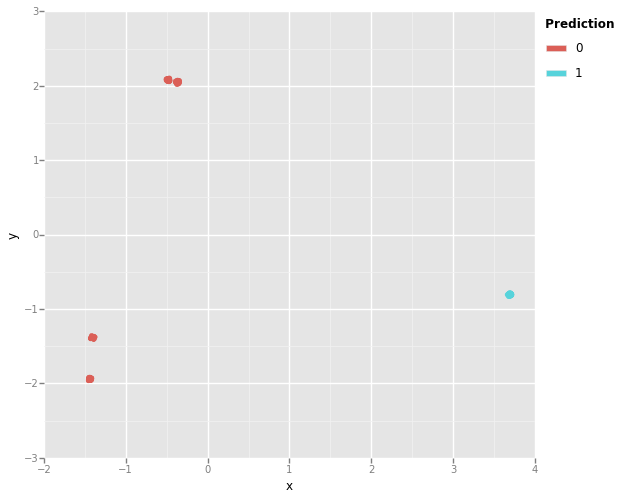

<ggplot: (-889724560)>

In [59]:
gg.ggplot(gg.aes(x="x", y="y", color="prediction"), data=ca1WithPredDF.toPandas()) + gg.geom_point()

Matome, kad $K = 2$ tikrai nėra optimalus klasterių kiekis. $\mathbb{R}^2$ atveju galime nubraižyti sklaidos diagramą, tačiau ką daryti $\mathbb{R}^p$, kai $p > 2$ atveju? 
Vienas iš būdų yra apmokyti keletą modelių su skirtingomis $K$ reikšmėmis ir juos palyginti pagal iš anksto apsibrėžtų charakteristikų reikšmes.

Sukuriame funkciją, apmokančią keletą K-vidurkių modelių su nurodytomis $K$ reikšmėmis

In [5]:
def trainKMeans(featuresRDD, kValues):
    res = []
    for k in kValues:
        model = KMeans.train(
            featuresRDD, k, maxIterations=10, 
            runs=10, initializationMode="k-means||", seed=1)
        res.append({"k": k, "SSE": model.computeCost(featuresRDD), "model": model})
    return res

In [91]:
def kmeansWSSSEsByK(featuresRDD, kValues):
    return [KMeans.train(featuresRDD, k=k, maxIterations=10, 
                         runs=10, initializationMode="k-means||", 
                         seed=1).computeCost(featuresRDD)
            for k in kValues]

In [92]:
kmeansWSSSEsByK(featuresRDD, [2,4,6])

[1504.98682886255, 0.7903686095224364, 0.09225786640582233]

Viena iš galimų charakteristikų nustatyti optimalią $K$ reikšmę yra aprašyta [čia](http://www.ee.columbia.edu/~dpwe/papers/PhamDN05-kmeans.pdf) ir [čia](https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/). Jos reikšmė $f(K)$ apskaičiuojama tokiu būdu:

<img src="https://datasciencelab.files.wordpress.com/2014/01/fk.png?w=359&h=192">

Optimilaus $K$ yra ties "alkūnine" $f(K)$ reikšme.

Pagal $f(K)$ išraišką matome, kad kiekvienam $K$ reikia turėti ir $S_{K-1}$ reišmes. Sukuriame reikalingas funkcijas.

In [113]:
import collections
Pham2004Results = collections.namedtuple("Pham2004Results", ["ks", "fKs"])

def computePham2004(featuresRDD, kValues):
    allKs = makeKs(kValues)
    WSSSEs = kmeansWSSSEsByK(featuresRDD, allKs)
    ksWithPairedWSSSEs = [
        (k, WSSSEs[allKs.index(k)], WSSSEs[allKs.index(k - 1)] if k - 1 > 0 else 0) 
        for k in kValues]
    dimension = len(featuresRDD.first())
    fKs = [
        computeFK(k, Sk, prevSk, dimension) 
        for (k, Sk, prevSk) in ksWithPairedWSSSEs]
    return Pham2004Results(kValues, fKs)

def makeKs(initialKs):
    allKs = [k - 1 for k in initialKs if k - 1 > 0] + initialKs
    return sorted(list(set(allKs)))

def computeFK(k, SSE, prevSSE, dim):
    if k == 1 or prevSSE == 0:
        return 1
    weight = weightFactor(k, dim)
    return SSE / (weight * dim)

def weightFactor(k, dim):
    if not k >= 2:
        raise ValueError("k must be greater than 1")
        
    weight = 1 - 3 / (4 * dim)
    i = 2
    while i < k:
        weight_prev = weight
        weight = weight_prev + (1 - weight_prev) / 6
        i += 1
    return weight

# tail recursion is not optimized in Python
# def weightFactor(k, dim):
#     if not k >= 2:
#         raise ValueError("k should be greater than 1,")
#     k2Weight = 1 - 3 / (4 * dim)
#     return weightFactorAccumulator(k2Weight, k)
#
# def weightFactorAccumulator(acc, k):
#     if k == 2:
#         return acc
#     return weightFactorAccumulator(acc + (1 - acc) / 6, k - 1)

In [124]:
ks, fKs = computePham2004(featuresRDD, [1,2,3,6])
print(ks)
print(fKs)

[1, 2, 3, 6]
[1, 1203.98946309004, 11.876601791043038, 0.05631281990436629]


In [135]:
Pham2004Row = Row("K", "fK")

def makePham2004DF(ks, fKs):
    rowContents = list(zip(ks, fKs))
    return sc.parallelize(
        [Pham2004Row(k, float(fK)) 
         for (k, fK) in rowContents]).toDF()

In [138]:
pham2004DF = makePham2004DF(ks, fKs)
pham2004DF.show()

+---+-------------------+
|  K|                 fK|
+---+-------------------+
|  1|                1.0|
|  2|   1203.98946309004|
|  3| 11.876601791043038|
|  6|0.05631281990436629|
+---+-------------------+



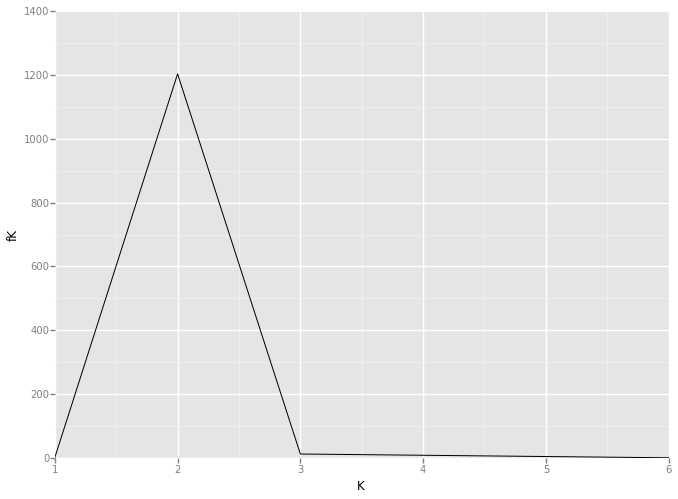

<ggplot: (-896663610)>

In [137]:
gg.ggplot(gg.aes(x="K", y="fK"), data=pham2004DF.toPandas()) + gg.geom_line()

In [140]:
pham2004DF.where(pham2004DF["K"] > 2).show()

+---+-------------------+
|  K|                 fK|
+---+-------------------+
|  3| 11.876601791043038|
|  6|0.05631281990436629|
+---+-------------------+



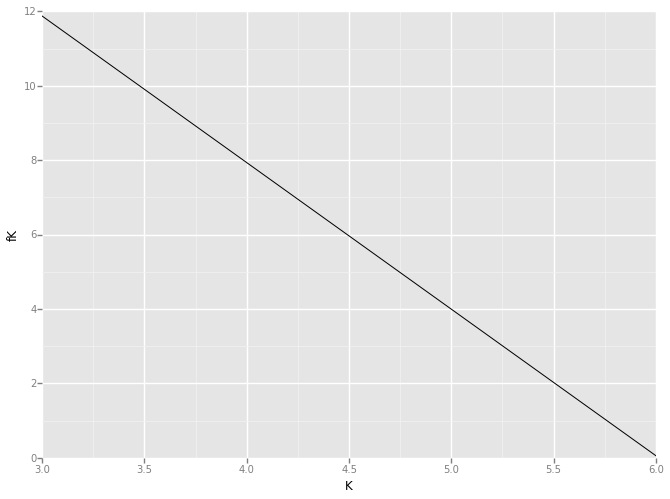

<ggplot: (-896686028)>

In [139]:
gg.ggplot(gg.aes(x="K", y="fK"), data=pham2004DF.where(pham2004DF["K"] > 2).toPandas()) + gg.geom_line()

Parinkime daugiau $K$ reikšmių.

In [142]:
moreKs = [2,3,4,5,6,7]


pham2004moreKsDF = makePham2004DF(*computePham2004(featuresRDD, moreKs))
pham2004moreKsDF.show()

+---+-------------------+
|  K|                 fK|
+---+-------------------+
|  2|   1203.98946309004|
|  3| 11.876601791043038|
|  4| 0.5343337078461542|
|  5| 0.0644715434241492|
|  6|0.05631281990436629|
|  7|0.04988912836653434|
+---+-------------------+



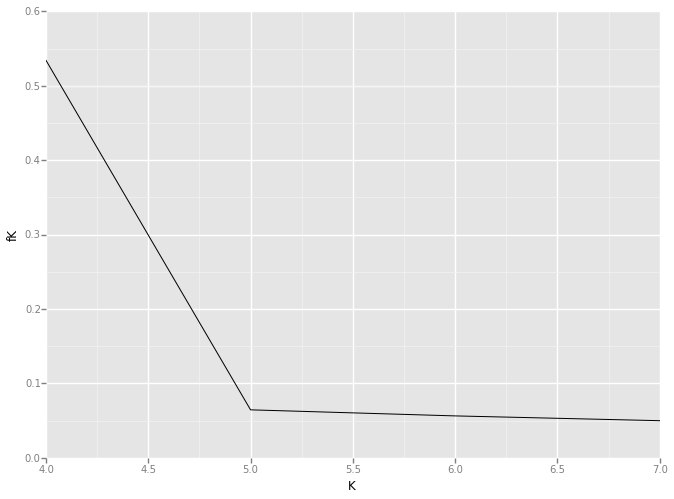

<ggplot: (-896663642)>

In [143]:
filteredPham2004moreKsDF = pham2004moreKsDF.where(pham2004moreKsDF["K"] > 3)
gg.ggplot(gg.aes(x="K", y="fK"), data=filteredPham2004moreKsDF.toPandas()) + gg.geom_line()

$K = 5$ yra optimali reikšmė.